# Segware - previsão de disparos verdadeiros

Um algoritmo com base em aprendizado de máquina e análise preditiva que preveja disparos verdadeiros (considerando o cenário abaixo).

Empresa de monitoramento (cliente Segware): toda a empresa que utiliza a plataforma desenvolvida pela Segware para tratar sinais (eventos) decorrentes de sistemas de alarmes eletrônicos (com sensores de movimento, por exemplo), câmeras e etc.

Um dos maiores causadores de custos para as empresas de monitoramento são os deslocamentos, ou seja, quando a empresa precisa enviar uma viatura (carro ou moto) até a residência ou comércio que está sendo monitorado.

Acontece que muitas vezes esses disparos são causados por cenários diversos, como: um galho de arvore balançando ao vento, tempestades, animais, ou mesmo pelo próprio cliente querendo fazer um teste para ver se a empresa de monitoramento está mesmo de olho.

Baseando-se nos arquivos train.cvs e test.cvs, desenvolva um algoritmo que preveja se o disparo é falso ou verdadeiro, indicando a precisão do resultado.


# Dicionário de dados:

*	Código do cliente: Código único do cliente dentro do sistema;

*	Nível de risco: grau de periculosidade do local, sendo 5 * mais alto;

*	Possui servidor CFTV: indica se * cliente possui monitoramento de imagens (0: não; 1:sim);

*	Pessoa física, jurídica ou orgão público: 0 = jurídica, 1 = física, 2 = órgão público;

*	Estado, Cidade, Bairro: Localidade do cliente;

*	Data/hora: data/hora da ocorrência do evento;

*	Código do evento: código do evento enviado;

*	Confirmado: indica se houve de fato um sinistro no cliente (0: não, 1: sim). 


* Instalação da lib imblearn que será usado no pipeline

In [80]:
# !pip install imblearn

* Importação de bibliotecas

In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc

from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# os.chdir('D:/Meus documentos/Trabalhos/python/exercicios/exemplaria/turma-2019-1/data/intermediate/')
# print()
# os.chdir('/kaggle/input/dataset')
# print('LOCAL DE DATABASES')
# print()
# print(os.getcwd())
# print()
# print('LISTA DE DATABASES \n\n -', end ='')
# print(*os.listdir(), sep = '\n -')

/kaggle/input/dataset/train.csv
/kaggle/input/dataset/test.csv


***
# 1) Leitura da base de dados de treinamento e test

In [82]:
train = pd.read_csv("../input/dataset/train.csv", sep=';')
train

,Código Cliente,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Estado,Cidade,Bairro,Data/hora,Código do evento,Confirmado
0,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:12.497,E131,1
1,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:17.440,E131,1
2,10049,5,0,0,SP,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:27.303,E131,1
3,11794,4,0,0,SP,SAO CARLOS,PARQUE SANTA MONICA,2019-01-01 00:12:09.100,E130,0
4,9658,5,1,0,SP,SAO CARLOS,CENTRO,2019-01-01 00:36:35.657,E131,1
...,...,...,...,...,...,...,...,...,...,...
995,11838,4,0,0,SP,SAO CARLOS,VILA ALPES,2019-01-03 19:17:54.680,E123,0
996,11799,3,0,1,SP,SAO CARLOS,VILA FARIA,2019-01-03 19:30:52.210,E132,0
997,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:43:52.017,E130,1
998,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:43:59.363,E130,1


In [83]:
test = pd.read_csv("../input/dataset/test.csv", sep=';')
test = test.rename(columns={'Código do evento ': 'Código do evento'})     # correção de espaçamento da coluna 'Código do evento'
test

,Código Cliente,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Estado,Cidade,Bairro,Data/hora,Código do evento
0,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:13.623,E130
1,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:21.167,E130
2,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:28.617,E130
3,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:36.127,E130
4,8984,4,1,2,SP,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:42.813,E130
...,...,...,...,...,...,...,...,...,...
995,11842,4,0,0,SP,SAO CARLOS,VILA LUTFALLA,2019-01-05 14:08:35.323,E130
996,11842,4,0,0,SP,SAO CARLOS,VILA LUTFALLA,2019-01-05 14:09:33.847,E130
997,11842,4,0,0,SP,SAO CARLOS,VILA LUTFALLA,2019-01-05 14:10:36.360,E130
998,11842,4,0,0,SP,SAO CARLOS,VILA LUTFALLA,2019-01-05 14:10:36.853,E130


***
# 2) Função para checagem de dados faltantes ou inválidos - com NaN - Not a number

* É muito comum as bases de dados virem com dados faltantes e/ou inválidos, sendo assim é muito importante a checagem destes.

In [84]:
def just_check_nan(df):
    missing_val_count_by_column = (df.isna().sum())           # Para trabalhar com valores nulos usar o isna, muito util para determinar quantidade de NaN
    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

* Chamada da função **'just_check_nan'**

In [85]:
just_check_nan(train)

Dados com NaN:
Series([], dtype: int64)

columns_with_nan.shape (0,)



# 3) Definição de target e features

* Target y

O target é o objetivo do modelo, ou seja, é o que se deseja prever na base de dados "test.csv".


O gráfico mostra a quantidade de sinistros com relação ao número total de clientes da base de treinamento.

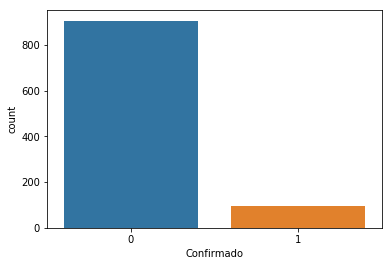

Com relação aos sinistros reais, da base de 1000 clientes, 95 destes sinistros foram reais , ou seja, 9.50%


<Figure size 432x288 with 0 Axes>

In [86]:
y = train.Confirmado

sns.countplot(x=y, data=train)
plt.show()
plt.savefig('count_plot')

print('Com relação aos sinistros reais, da base de ' + str(len(train)) + ' clientes, ' + str(Counter(y)[1]) + ' destes sinistros foram reais , ou seja, %.2f' \
      %float((Counter(y)[1]/len(train))*100) + '%')
#se houve de fato um sinistro no cliente

* Features X

As features são os dados que o modelo usará para fazer as previsões. 

Análise critica:
- neste caso, **as features escolhidas** são as que mais casam com as causas dos disparos, acidentais ou não.
- Exclui 'código cliente' por não achar que este é um causador de disparo, e o modelo pode associar de forma incorreta os valores com as causas dos disparos
- Exclui 'estado' por haver apenas 1.

In [87]:
features = ['Nível de risco', 'Possui servidor CFTV', 'Pessoa Física, Jurídica, ou Órgão Público', 'Cidade', 'Bairro', 'Data/hora', 'Código do evento']

X = train[features]    # X representa então a base train com as features escolhidas para o modelo
X

,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Cidade,Bairro,Data/hora,Código do evento
0,5,0,0,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:12.497,E131
1,5,0,0,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:17.440,E131
2,5,0,0,SAO CARLOS,JARDIM IPANEMA,2019-01-01 00:02:27.303,E131
3,4,0,0,SAO CARLOS,PARQUE SANTA MONICA,2019-01-01 00:12:09.100,E130
4,5,1,0,SAO CARLOS,CENTRO,2019-01-01 00:36:35.657,E131
...,...,...,...,...,...,...,...
995,4,0,0,SAO CARLOS,VILA ALPES,2019-01-03 19:17:54.680,E123
996,3,0,1,SAO CARLOS,VILA FARIA,2019-01-03 19:30:52.210,E132
997,4,1,2,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:43:52.017,E130
998,4,1,2,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:43:59.363,E130


* Variaveis Numéricas

Neste caso, está sendo feita uma análise de quantas variavéis numéricas existem nas features escolhidas

In [88]:
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  3
['Nível de risco', 'Possui servidor CFTV', 'Pessoa Física, Jurídica, ou Órgão Público']


* Variaveis Categóricas

Neste caso, está sendo feita uma análise de quantas variavéis categóricas existem nas features escolhidas, exije uma atenção especial pelo fato do pipeline irá transformar estas variaveis em variaveis binárias, usando **'one hot enconding'**.

In [89]:
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  4
['Cidade', 'Bairro', 'Data/hora', 'Código do evento']


# 4) train_test_split

Aqui é feita a separação dos dados de treinamento (X_train, y_train) e de teste (X_test, y_test), onde é feita a separação de 60% para o treinamento e 40% para os testes

In [90]:
# 70% for train data and 30% for test data SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.4,
                                                    random_state=42)

# 5) Pipeline

O Pipeline é uma série de algoritmos encadeados, compostos e misturados de algumas maneiras para processar um fluxo de dados, recebe entradas e fornece saídas

In [91]:
# Pré-processamento para Dados numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler()) # SCALER - muda valores de escala para valores menores
                                ])

# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))   # transforma dados categorios em binário
                                   ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                               ('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

# MODEL
model = LogisticRegression()

## Bundle preprocessing and modeling code in a pipeline
# Base de dados desbalanceadas, ou seja, neste caso, poucos sinistros para muitos clientes, 
# é um problema para o modelo, este pode acusar que nunca há sinistros, os que acusam sinistro podem estar num
pipeline = Pipeline(steps=[
                           ('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42, n_jobs=-1)),
                           ('model', model)
                          ])

# 6) Fit

Pré-processamento de dados de treinamento

In [92]:
# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Nível de risco',
                                                   'Possui servidor CFTV',
                                               

# 7) Predict

É onde feito as previsões. Há um contador mostrando justamente a quantidade de sinistros previstos, baseado no X_test (400 clientes total)

In [93]:
preds = pipeline.predict(X_test)
print('preds: ', Counter(preds))

preds:  Counter({0: 365, 1: 35})


# 8) Metrics

A curva ROC mostra o quanto o modelo consegue distinguir entre as classes (sinistro e não sinistro). Neste caso, possui 96% de chance de conseguir distinguir corretamente as classes.

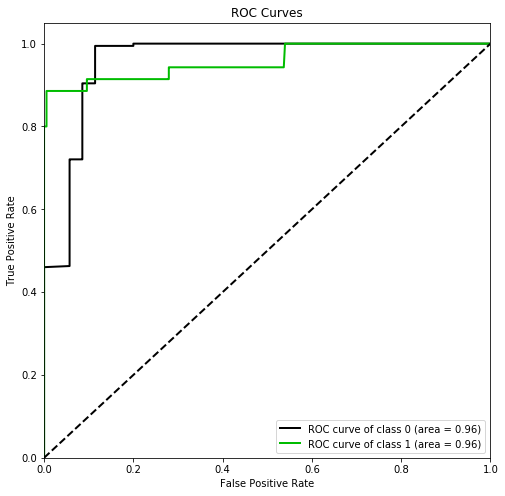

In [94]:
y_probas = pipeline.predict_proba(X_test)
plot_roc(y_test, y_probas, plot_micro = False, plot_macro = False, figsize = (8, 8))
plt.show()

* Confusion Matrix

É uma medida de desempenho para o problema de classificação de aprendizado de máquina em que a saída pode ser de duas ou mais classes
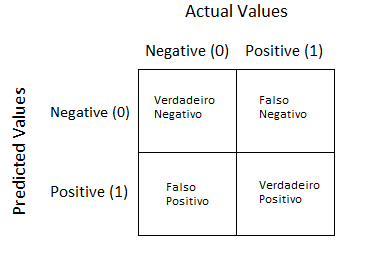

In [95]:
conf_matrix = confusion_matrix(y_test, preds)

print('               Actual Values')
print('           +--------+--------+')
print('           | Neg(0) | Pos(1) |')
print('p +--------+--------+--------+')
print('r | Neg(0) | ' + str(conf_matrix[0][0]) + '    | ' + str(conf_matrix[0][1]) + '      |')
print('e +--------+--------+--------+')
print('d | Pos(1) | ' + str(conf_matrix[1][0]) + '      | ' + str(conf_matrix[1][1]) + '     |')
print('s +--------+--------+--------+')

               Actual Values
           +--------+--------+
           | Neg(0) | Pos(1) |
p +--------+--------+--------+
r | Neg(0) | 361    | 4      |
e +--------+--------+--------+
d | Pos(1) | 4      | 31     |
s +--------+--------+--------+


**precision** é a capacidade de um classificador de não rotular uma instância de positiva como realmente negativa. Para cada classe, é definida como a razão entre os verdadeiros positivos e a soma dos verdadeiros positivos e falsos positivos. Dito de outra maneira, **"para todos os casos classificados como positivos, qual porcentagem estava correta?"
Caso: O modelo previu 35 reclamantes, acertou 31, precisão de 89%**

**recall** é capacidade de um classificador encontrar todas as instâncias positivas. Para cada classe, é definida como a razão entre os verdadeiros positivos e a soma dos verdadeiros positivos e falsos negativos. **Dito de outra maneira, "para todas as instâncias que foram realmente positivas, qual porcentagem foi classificada corretamente?"
Caso: Dos 35 casos reais de reclamantes, ele acertou 31, que é 89%**

**F1 score** é uma média harmônica ponderada de precision e recall, de modo que a melhor pontuação seja 1,0 e a pior seja 0,0. De um modo geral, os valores de F1 score são mais baixas do que as medidas de precision como eles incorporam precision e recall em seu cálculo.

**support** é o número de ocorrências reais da classe no conjunto de dados especificado. O suporte desequilibrado nos dados de treinamento pode indicar fragilidades estruturais nas pontuações relatadas do classificador e pode indicar a necessidade de amostragem estratificada ou reequilíbrio. O suporte não muda entre os modelos, mas sim diagnostica o processo de avaliação.

In [96]:
# classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       365
           1       0.89      0.89      0.89        35

    accuracy                           0.98       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.98      0.98      0.98       400



# 9) Make Predictions

In [97]:
X_eval = test[features]
X_eval

,Nível de risco,Possui servidor CFTV,"Pessoa Física, Jurídica, ou Órgão Público",Cidade,Bairro,Data/hora,Código do evento
0,4,1,2,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:13.623,E130
1,4,1,2,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:21.167,E130
2,4,1,2,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:28.617,E130
3,4,1,2,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:36.127,E130
4,4,1,2,SAO CARLOS,RESID MONS ROMEU TORTORELLI,2019-01-03 19:44:42.813,E130
...,...,...,...,...,...,...,...
995,4,0,0,SAO CARLOS,VILA LUTFALLA,2019-01-05 14:08:35.323,E130
996,4,0,0,SAO CARLOS,VILA LUTFALLA,2019-01-05 14:09:33.847,E130
997,4,0,0,SAO CARLOS,VILA LUTFALLA,2019-01-05 14:10:36.360,E130
998,4,0,0,SAO CARLOS,VILA LUTFALLA,2019-01-05 14:10:36.853,E130


In [98]:
test_preds = pipeline.predict(X_eval)
test_preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [99]:
print('preds: ', Counter(test_preds))

preds:  Counter({0: 714, 1: 286})


# 10) Output file

Create a csv output file

In [100]:
output_test = pd.DataFrame({'Código Cliente': test['Código Cliente'],
                           'Nível de risco' : test['Nível de risco'],
                           'Possui servidor CFTV' : test['Possui servidor CFTV'],
                           'Pessoa Física, Jurídica, ou Órgão Público' : test['Pessoa Física, Jurídica, ou Órgão Público'],
                           'Estado' : test['Estado'],
                           'Cidade' : test['Cidade'],
                           'Bairro' : test['Bairro'],
                           'Data/hora' : test['Data/hora'],
                           'Código do evento' : test['Código do evento'],
                           'Confirmado' : test_preds
                          })
output_test.to_csv('submission_test.csv', index=False)